In [901]:
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import psycopg2 as pg
import psycopg2.extras
from plotly.offline import plot, iplot
import plotly.graph_objs as go
import requests
from scipy.optimize import minimize
import numpy as np

def getLastNdays(symbol,days,src = 'yahoo'):
    try:
        end = dt.datetime.now()
        start = end - dt.timedelta(days=days)
        df = pdr.DataReader(symbol, src, start, end)
        js = df.to_json()
    except:
        return None
    else:
        return js

def saveData(symbol,jsstr,dburl):
    conn = pg.connect(dburl)
    cur = conn.cursor()
    cur.execute('insert into stockdata (symbol,csvdata) values (%s,%s)',(symbol,jsstr))
    conn.commit()
    cur.close()
    conn.close()

def getSymbolData(symbol,dburl):
    try:
        conn = pg.connect(dburl)
        cur = conn.cursor()
        cur.execute('select * from stockdata where symbol = %s order by created desc limit 1',(symbol,))
        rows = cur.fetchall()
        cur.close()
        conn.close()   
        df = pd.read_json(rows[0][1])
    except:
        return None
    else:
        return df

def createTraces(df):
    traces = []
    for c in df:
        traces.append(go.Scatter(
            x = df.index,
            y = df[c],
            mode = 'lines',
            name = c,
            visible = True
        ))
    return traces

def plotTraces(traces,title,xaxis_label,yaxis_label,output_type='div'):
    layout = dict(
        hovermode = 'closest',
        showlegend = True,
        title = title,
        yaxis = dict(title = yaxis_label),
        xaxis = dict(title = xaxis_label),
        plot_bgcolor = '#E2E3E5'
    )
    data = traces
    fig = dict(data=data, layout=layout)
    div = plot(fig, output_type=output_type,config=dict(displayModeBar=True,showLink=False))
    return div  
  
def getPlot(symbol,df,days,output_type='div'):
    labels = ["All Days","Last 30","Last 60","Last 90"]
    vis = [[True,False,False,False],
           [False,True,False,False],
           [False,False,True,False],
           [False,False,False,True]]
    traces = []
    for i,d in enumerate(df):
        traces.append(go.Scatter(
            x = d.index,
            y = d['Adj Close'],
            mode = 'lines',
            name = str.format('Adj Close {}',labels[i]),
            visible = True if i==0 else False
        ))

    buttons = []
    for i,t in enumerate(traces):
        buttons.append(
            dict(label = t.name,
                 method = 'update',
                 args = [{'visible': vis[i]}])
        )
        
    updatemenus = list([
        dict(active=0,
             buttons=buttons,
             x=0.1,
             y=1.2
        )
    ])

    layout = dict(
        hovermode = 'closest',
        showlegend = True,
        title = str.format('{} Price',symbol),
        yaxis = dict(title = 'Price'),
        xaxis = dict(title = 'Date'),
        plot_bgcolor = '#E2E3E5',
        updatemenus=updatemenus
    )
    
    data = traces
    fig = dict(data=data, layout=layout)
    div = plot(fig, output_type=output_type,config=dict(displayModeBar=True,showLink=False))
    return div  

def frontierPlot(vol_arr,ret_arr,sharpe_arr,height,width,max_sr_vol,max_sr_ret,output_type='div'):
    trace = go.Scatter(
        x = vol_arr,
        y = ret_arr,
        mode='markers',
        marker=dict(
            size='8',
            color = sharpe_arr, #set color equal to a variable
            colorscale='Portland',
            colorbar = dict(title='Sharpe Ratio'),
            showscale=True
        )
    )

    xsize = vol_arr.max()-vol_arr.min()
    ysize = ret_arr.max()-ret_arr.min()
    markerxradius = 0.015 * xsize 
    markeryradius = 0.015 * ysize * (width/height)

    layout = dict(
        hovermode = 'closest',
        height = height,
        width = width,
        yaxis = dict(title = 'Return'),
        xaxis = dict(title = 'Risk'),
        title = 'Efficient Frontier',
        plot_bgcolor = '#E2E3E5',
        shapes = [
            dict(
                type='circle',
                x0=max_sr_vol-(markerxradius),
                x1=max_sr_vol+(markerxradius),
                y0=max_sr_ret-(markeryradius),
                y1=max_sr_ret+(markeryradius),
                xref='x',
                yref='y',
                fillcolor='rgba(255,0,0,1)',
                line=dict(
                    width=3,
                    color='rgba(0,0,0,1)'
                )
            )
        ]
    )

    data = [trace]

    fig = dict(
        data=data, 
        layout=layout)    

    div = plot(fig, output_type=output_type,config=dict(displayModeBar=True,showLink=False))
    return div  

def frontierPlot2(vol_arr,ret_arr,sharpe_arr,height,width,max_sr_vol,max_sr_ret,output_type='div'):
    trace = go.Scatter(
        x = vol_arr,
        y = ret_arr,
        mode='markers',
        marker=dict(
            size='8',
            color = sharpe_arr, #set color equal to a variable
            colorscale='Portland',
            colorbar = dict(title='Sharpe Ratio'),
            showscale=True
        )
    )

    xsize = vol_arr.max()-vol_arr.min()
    ysize = ret_arr.max()-ret_arr.min()
    markerxradius = 0.015 * xsize 
    markeryradius = 0.015 * ysize * (width/height)

    layout = dict(
        hovermode = 'closest',
        height = height,
        width = width,
        yaxis = dict(title = 'Return'),
        xaxis = dict(title = 'Risk'),
        title = 'Efficient Frontier',
        plot_bgcolor = '#E2E3E5',
        shapes = [
            dict(
                type='circle',
                x0=max_sr_vol-(markerxradius),
                x1=max_sr_vol+(markerxradius),
                y0=max_sr_ret-(markeryradius),
                y1=max_sr_ret+(markeryradius),
                xref='x',
                yref='y',
                fillcolor='rgba(255,0,0,1)',
                line=dict(
                    width=3,
                    color='rgba(0,0,0,1)'
                )
            )
        ]
    )

    data = [trace]

    fig = dict(
        data=data, 
        layout=layout)    

    div = plot(fig, output_type=output_type,config=dict(displayModeBar=True,showLink=False))
    return div  


def get_ret_vol_sr(weights,stocks):
    """
    Takes in weights, returns array of return, volatility, sharpe ratio.
    assumes data is daily - conversion 252
    """
    log_ret = np.log(stocks/stocks.shift(1))
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    shrp = ret/vol
    return np.array([ret,vol,shrp])

def neg_sharpe(weights,stocks):
    ''' Given some weights we calculate the sharp ratio. Since this is a minimization problem. we express
        the negative result
    '''
    return  get_ret_vol_sr(weights,stocks)[2] * -1

# Contraints - on the the input weights
def check_sum(weights):
    '''
    Returns 0 (ok) if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def getPortfolioPrices(symbols,dburl):
    dfs = []
    for s in symbols:
        dfs.append(getSymbolData(s,dburl)['Adj Close'])
    df = pd.concat(dfs,axis=1)
    df.columns = symbols
    df = df.dropna()
    return df

def normPortfolio(symbols,dburl):
    df = getPortfolioPrices(symbols,dburl)
    df = df/df.shift(1)
    return df.iloc[1:]

def monteCarloPortfolios(stocks,num_ports):
    all_weights = np.zeros((num_ports,len(stocks.columns)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)
    log_ret = np.log(stocks/stocks.shift(1))

    for ind in range(num_ports):

        # Create Random Weights
        weights = np.array(np.random.random(len(stocks.columns)))

        # Rebalance Weights
        weights = weights / np.sum(weights)

        # Save Weights
        all_weights[ind,:] = weights

        # Expected Return
        ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

        # Expected Variance
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

        # Sharpe Ratio
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
        
    maxidx = sharpe_arr.argmax()
    max_sr_ret = ret_arr[maxidx]
    max_sr_vol = vol_arr[maxidx]
    
    return (vol_arr,ret_arr,sharpe_arr,max_sr_ret,max_sr_vol)

In [885]:
dburl = "dbname=moshea user=moshea"

In [385]:
symbol = 'CAT'
jsstr = getLastNdays(symbol,90)
if jsstr != None:
    saveData(symbol,jsstr,dburl)

In [359]:
import numpy as np
%matplotlib inline

In [313]:
df = getSymbolData(symbol,dburl)
df20 = df.iloc[-20:]
df40 = df.iloc[-40:]
df60 = df.iloc[-60:]

In [460]:
df = normPortfolio(['AAPL','CSCO','FB','GOOG','AMZN'],dburl)
traces = createTraces(df)
plotTraces(traces,'Returns','Data','Return',output_type='file')

'file:///Users/moshea/Python-for-Finance-Repo-master/06-Data-Sources/temp-plot.html'

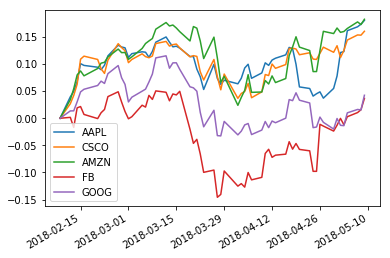

In [461]:
dfappl = getSymbolData('AAPL',dburl)['Adj Close']
dfcsco = getSymbolData('CSCO',dburl)['Adj Close']
dfamzn = getSymbolData('AMZN',dburl)['Adj Close']
dffb = getSymbolData('FB',dburl)['Adj Close']
dfgoog = getSymbolData('GOOG',dburl)['Adj Close']
df = pd.concat([dfappl,dfcsco,dfamzn,dffb,dfgoog],axis=1)
df.columns = ['AAPL','CSCO','AMZN','FB','GOOG']
df = df.dropna()
stock_normed = np.log(df/df.iloc[0])
stock_normed.plot()

In [367]:
traces = createTraces(stock_normed)
plotTraces(traces,'Returns','Date','Return',output_type='file')

'file:///Users/moshea/Python-for-Finance-Repo-master/06-Data-Sources/temp-plot.html'

In [314]:
df20.head()

,Adj Close,Close,High,Low,Open,Volume
2018-04-11,166.320007,166.320007,168.649994,163.250000,165.360001,56144600
2018-04-12,163.869995,163.869995,167.449997,163.100006,166.979996,38263000
2018-04-13,164.520004,164.520004,165.699997,163.770004,164.580002,19990600
2018-04-16,164.830002,164.830002,165.779999,163.389999,165.720001,18119400
2018-04-17,168.660004,168.660004,169.000000,165.660004,165.830002,22743000


In [323]:
r = requests.put("https://futurtrends-fintools.herokuapp.com/symdata", 
                 json={'symbol':symbol, 'js':jsstr})
print(r.content)

b'added GOOG'


In [320]:
getPlot(symbol,[df,df20,df40,df60],90,output_type='file')

'file:///Users/moshea/Python-for-Finance-Repo-master/06-Data-Sources/temp-plot.html'

In [330]:
def update_prices(symbol,url):
    js = getLastNdays(symbol,90)
    if jsstr != None:
        saveData(symbol,jsstr,url)

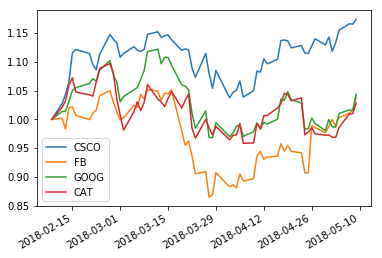

In [773]:
df = getPortfolioPrices(['CSCO','FB','GOOG','CAT'],dburl)
(df/df.iloc[0]).plot()

6.666666666666667

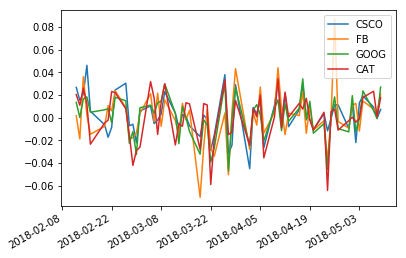

In [774]:
np.log((df/df.shift(1))).plot()

In [775]:
import matplotlib.pyplot as plt
%matplotlib inline
dburl = "dbname=moshea user=moshea"

In [903]:
df = getPortfolioPrices(['CSCO','FB','GOOG','CAT'],dburl)
vol_arr, ret_arr, sharpe_arr, max_sr_ret, max_sr_vol = monteCarloPortfolios(df,100)
frontierPlot2(vol_arr,ret_arr,sharpe_arr,500,800,max_sr_vol,max_sr_ret,'file')

'file:///Users/moshea/Python-for-Finance-Repo-master/06-Data-Sources/temp-plot.html'

In [778]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = [(0,1)]*len(df.columns)

# Initial Guess (equal distribution of weights)
init_guess = np.array(([1.0]*len(df.columns)))/len(df.columns)

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,args=(df,),method='SLSQP',bounds=bounds,constraints=cons)

In [779]:
opt_results

     fun: -2.3350110367073107
     jac: array([  2.98023224e-08,   1.06589711e+00,   1.28624347e+00,
         1.39940295e+00])
 message: 'Optimization terminated successfully.'
    nfev: 12
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 1.,  0.,  0.,  0.])

In [780]:
optimal_allocation = [a for a in zip(df.columns,np.round(opt_results.x*100,decimals=2))]
optimal_allocation

[('CSCO', 100.0), ('FB', 0.0), ('GOOG', 0.0), ('CAT', 0.0)]